# Курсовой проект 
# Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn

### Задание для курсового проекта <a class='anchor' id='course'>

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Соревнование заканчивается 10.01.21
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров. 

### Load packegs

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

from sklearn.preprocessing import LabelEncoder #для кодирования категориальных признаков

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Download dataset

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
train_df.head(25)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


### Memory optimization

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


***посмотр и приведение типов данных стоблцов (признаков)***

In [11]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## EDA (exploratory data analysis)

***target***

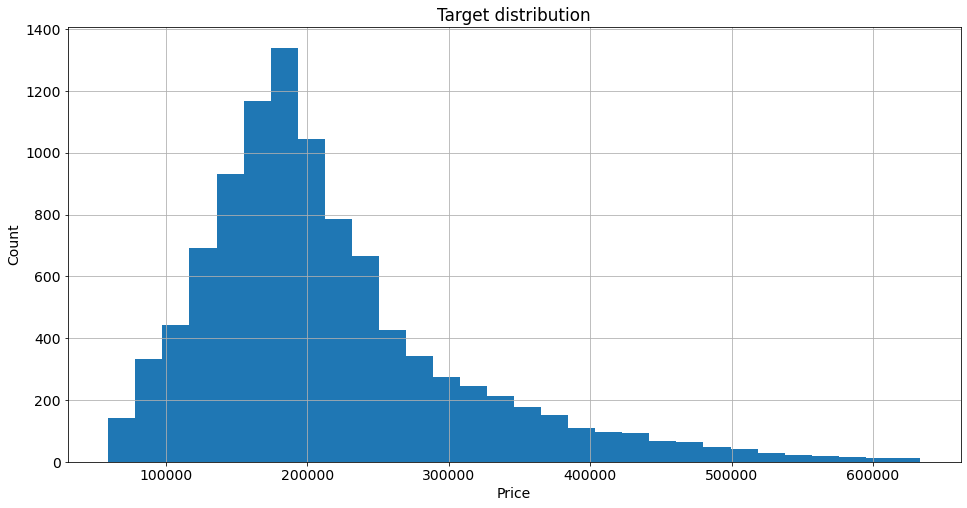

In [13]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

***количественные переменые***

In [14]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### Обработка выбросов 

Rooms

In [15]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [16]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head(100)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16695,23,1.0,36.931545,NaN,1.0,8,17.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,123225.906250,0
96,14717,21,1.0,37.572872,23.111217,6.0,5,6.0,1962,0.034331,...,B,25,5487,3,NaN,0,4,B,178032.890625,0
97,13145,58,2.0,49.871635,31.127615,6.0,3,9.0,1969,0.148904,...,B,9,1952,1,1430.0,3,2,B,152555.765625,0
98,7028,111,2.0,54.392899,30.792076,8.0,15,17.0,1990,0.000000,...,B,36,6714,2,2672.0,0,2,B,214439.609375,0


In [17]:
train_df['Rooms_outlier'] = 1
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,1
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,1
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,1
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,...,B,52,10311,6,NaN,1,9,B,119367.453125,1
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,199715.156250,1
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,...,B,20,4386,14,NaN,1,5,B,165953.906250,1
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,B,47,8004,3,125.0,3,5,B,171842.406250,1


In [18]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [19]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,1
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,1
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,1
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,1
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,...,B,52,10311,6,NaN,1,9,B,119367.453125,1
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,199715.156250,1
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,...,B,20,4386,14,NaN,1,5,B,165953.906250,1
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,B,47,8004,3,125.0,3,5,B,171842.406250,1


In [20]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

KitchenSquare

In [21]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [22]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [23]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [24]:
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
6.0     1227
5.0     1169
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
4.0       39
Name: KitchenSquare, dtype: int64

HouseFloor, Floor

In [25]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [26]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [27]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [28]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [29]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [30]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [31]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [32]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

HouseYear

In [33]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [34]:
train_df[train_df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier
8828,11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,...,25,4756,16,2857.0,5,8,B,243028.609375,1,0
9163,10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,...,30,6141,10,262.0,3,6,B,254084.531250,1,0


In [35]:
train_df['HouseYear'].mode()

0    1977
Name: HouseYear, dtype: int32

In [36]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = train_df['HouseYear'].mode()

In [37]:
train_df[train_df['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier


### Обработка пропусков 

In [38]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                2
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [39]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027313,NaN,10.0
1,39.832523,23.169222,8.0
2,78.342216,47.671970,10.0
3,40.409908,NaN,3.0
4,64.285065,38.562515,9.0
5,62.528465,47.103832,6.0
6,33.938751,21.772930,9.0
7,50.391815,32.893257,8.0
8,46.887894,44.628132,3.0
9,79.867477,75.085129,3.0


LifeSquare

In [40]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

Healthcare_1

In [41]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [42]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

#### Кодирование Категориальных Признаков (Encoding Categorical Features)¶

в датасете имеются категориальные признаки: столбцы - Ecology_2, Ecology_3, Shops_2

In [43]:
enc = LabelEncoder()
train_df['Ecology_2'] = enc.fit_transform(train_df['Ecology_2'])
train_df['Ecology_2']

0       1
1       1
2       1
3       1
4       1
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: Ecology_2, Length: 10000, dtype: int32

кодирование для столбца Ecology_3

In [44]:
enc = LabelEncoder()
train_df['Ecology_3'] = enc.fit_transform(train_df['Ecology_3'])
train_df['Ecology_3']
train_df['Ecology_3']

0       1
1       1
2       1
3       1
4       1
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: Ecology_3, Length: 10000, dtype: int32

кодирование для столбца Shops_2

In [45]:
enc = LabelEncoder()
train_df['Shops_2'] = enc.fit_transform(train_df['Shops_2'])
train_df['Shops_2']
train_df['Shops_2']

0       1
1       1
2       1
3       1
4       1
       ..
9995    1
9996    0
9997    1
9998    1
9999    1
Name: Shops_2, Length: 10000, dtype: int32

In [46]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

### Отбор признаков 

In [47]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan']

In [48]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

## Разбиение на train и test 

In [49]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [51]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [52]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [53]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [54]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

## Построение модели

#### Обучение

In [55]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=21)

#### Оценка модели

Train R2:	0.967
Test R2:	0.673


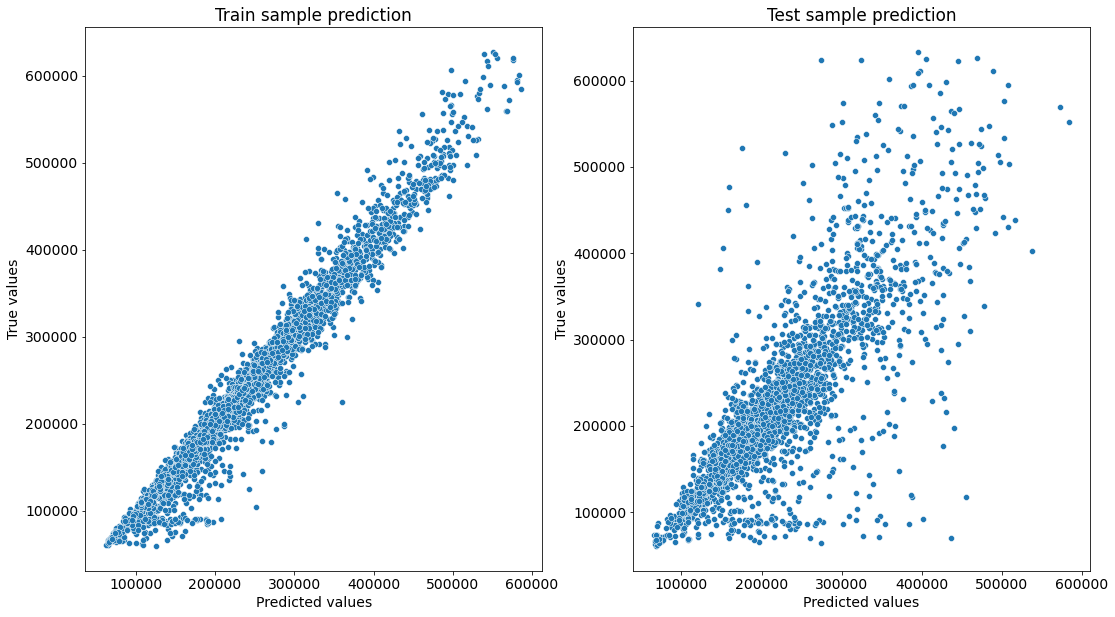

In [56]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [57]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73567661, 0.76301051, 0.75977236])

In [58]:
cv_score.mean()

0.7528198274145436

#### Важность признаков

In [59]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
23,MedPriceByDistrict,0.650295
1,Square,0.116160
2,LifeSquare,0.030049
6,HouseYear,0.025517
24,MedPriceByFloorYear,0.021401
20,DistrictSize,0.020551
5,HouseFloor,0.019063
3,KitchenSquare,0.017545
12,Social_3,0.016032
4,Floor,0.015123


## Прогнозирование на тестовом датасете 

In [60]:
test_df.shape

(5000, 25)

In [61]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,0,0,0,0,70.0,0,0,167155.991565,189479.726551
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,164.0,0,1,128808.353899,169603.426887
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1,0,0,0,1,568.0,0,1,164457.432677,174339.691014
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,1,0,0,0,0,375.0,0,1,157606.065847,182354.287699
4,1.0,53.837056,47.837056,3.0,8,17.0,1977,0.309479,1,1,...,1,0,0,0,1,76.0,0,0,162138.526832,190198.355458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,5,5.0,1962,0.069660,1,1,...,1,0,1,0,0,59.0,0,0,182289.757727,189479.726551
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,1,0,0,0,0,25.0,0,0,419315.944641,218975.318679
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,1,0,0,0,0,69.0,0,0,148430.871401,182354.287699
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,1,0,0,0,0,35.0,0,0,166024.537530,190198.355458


In [62]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [63]:
predictions = rf_model.predict(test_df)
predictions

array([162832.43885028, 119621.07384563, 143020.19377785, ...,
       144892.0945023 , 178119.82250555, 261541.86019476])

In [64]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,162832.438850
1,5925,119621.073846
2,960,143020.193778
3,3848,148260.780768
4,746,172101.230135


In [65]:
submit.to_csv('course_project_submit.csv', index=False)